### Data mining project on supply chain order lead time

Typical operations of order processing in a supply chain involves a number of dates of events regarding different stages of progress or committment of a purchasing order. Particularly for delivery of products, lead time would be one of the key performance indicators in evaluating the productivity of factories and customer service level satisfactions offered. This artificial simulated dataset consists of 15 columns on over 30,000 records. 

A common flow of analyzing lead time features may be a combined approach of unsupervised and supervised learning methods, I attempted to use R coding environment to attain the following purposes of :
1.	 Clustering <br/>
    •	 Divide the orders into sub-groups by different types of lead time helped to recognize latent patterns.
2.	 Anomaly Detection <br/>
    •	 It would be a good alert in practice if we could investigate whether some data would appear to be anomalous. 
3.	 Predictive Modelling <br/>
    •	 With a scope to control lead time for order processing, regression model for prediction was required.


In [7]:
## import dataset from directory
library(readxl)
LT <- read_excel("supply_order_LT1.xlsx", sheet="supply_order_LT1")

In [8]:
## convert the categorical variables from character to factor
LT[,names(LT[, 1:7])] = lapply(LT[,names(LT[, 1:7])], factor)
LT[,names(LT[, 11:12])] = lapply(LT[,names(LT[, 11:12])], ordered)

In [9]:
## exclude incomplete data
LT_d2 <- LT[complete.cases(LT),]
## check variable types
print(unlist(sapply(LT, class)))

             Item      Vendor.Class            Region          Category 
         "factor"          "factor"          "factor"          "factor" 
           Vendor             Brand          Customer  Unit.Price.per.K 
         "factor"          "factor"          "factor"         "numeric" 
    Scheduled.Qty         Actual.LT      FactorySize1      FactorySize2 
        "numeric"         "numeric"         "ordered"          "factor" 
     MinOrderQty1      MinOrderQty2         Quoted.LT Dev.Quote.Confirm 
        "ordered"          "factor"         "numeric"         "numeric" 
        PlannedLT 
        "numeric" 


In [10]:
## number of levels for nominal variables
print(sapply(LT_d2[, sapply(LT_d2, is.factor)], nlevels))

        Item Vendor.Class       Region     Category       Vendor        Brand 
        2160            3            4            6           46           86 
    Customer  FactorySize  MinOrderQty 
         293            4            3 


In [11]:
## print the features in the dataset
library(knitr)
options(width=500)
kable(data.frame(LT_d2[1:2,1:10]))
kable(data.frame(LT_d2[1:2,11:15]))



|Item  |Vendor.Class |Region |Category |Vendor |Brand |Customer | Unit.Price.per.K| Scheduled.Qty| Actual.LT|
|:-----|:------------|:------|:--------|:------|:-----|:--------|----------------:|-------------:|---------:|
|C0683 |China        |AP     |GL2      |B      |MLP   |1064994  |         3241.828|          1240|       143|
|C0677 |China        |AP     |GL2      |B      |MLP   |1064994  |         5799.163|          1101|       196|



|FactorySize |MinOrderQty | Quoted.LT| Dev.Quote.Confirm| PlannedLT|
|:-----------|:-----------|---------:|-----------------:|---------:|
|2           |2           |       169|               -30|        72|
|2           |1           |       190|                 5|        92|

As shown above, there is a large variation in the number of levels across the categorical variables. Creating dummy (one-hot encoded) variables for each level may increase sparsity and dimensionality of the data considerably. In case of matrix decomposition methods like multiple correspondence analysis (MCA) or categorical principal component analysis (CATPCA) were used, it might still require a large number of dimensions to get an acceptable or adequate proportion of variance explained. Regressions with large number of X inputs are difficult to tune.

Therefore, gathering observations through clustering would be able to find implicitly similar units into smaller size of categorical groups. To cluster categorical inputs, algorithms like K-modes (modified version of K-means) or ROCK (Robust Clustering with Links) are relatively common to handle these problems. K-modes is based on the simple matching distance (counting the proportion of non-matching cases between data points and the centroid that is found by the modes of each categorical input within the cluster).

<img src="https://slideplayer.com/slide/10920545/39/images/14/K-modes+clustering+Distance+function.jpg" width="300" height="300"/>

In [14]:
library(klaR)
library(ggplot2)
## k-modes clustering from 10 clusters to 300 clsuters
kmode_model = list(list())
select_kmode = list()
r = 1
for (km in seq(10, 300, 10)){
  kmode_model[[r]] = kmodes(as.data.frame(LT_d2[, c(1:7, 11:12)]), km, iter.max=100)
  select_kmode[r] = sum(kmode_model[[r]]$withindiff)
  r = r + 1
}

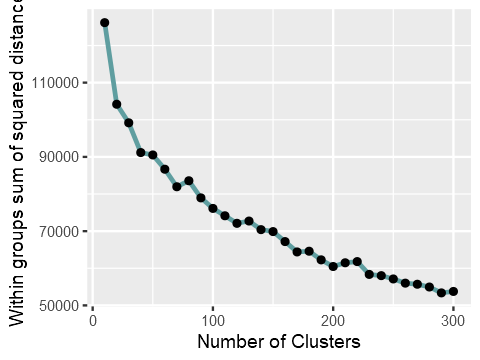

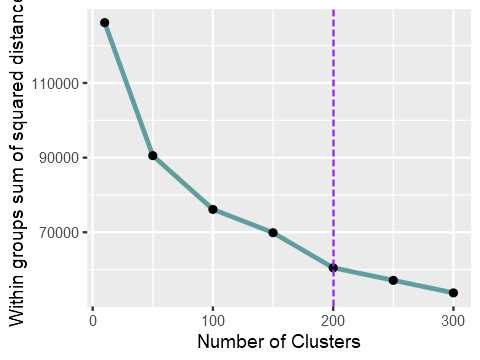

In [15]:
options(repr.plot.width=4, repr.plot.height=3)

## Visualize the scree-plot of within-group simple matching distance against number of clusters
LT_kmode_num_cluster <- data.frame(cbind(unlist(10 * seq(1, 30)), 
                  unlist(select_kmode)))
colnames(LT_kmode_num_cluster) <- c("number_of_cluster", 
                           "withingroup.simple.match.dist")

ggplot(data=LT_kmode_num_cluster, 
aes(x=number_of_cluster, y=withingroup.simple.match.dist, group=1)) + 
       geom_line(color="cadetblue", size = 1.0) +
       geom_point() + 
       labs(x="Number of Clusters", y="Within groups sum of squared distances")

ggplot(data=LT_kmode_num_cluster[c(1, 5, 10, 15, 20, 25, 30), ], 
       aes(x=number_of_cluster, y=withingroup.simple.match.dist, group=1)) + 
       geom_line(color="cadetblue", size = 1.0) +
       geom_point() + 
       geom_vline(xintercept = 200, colour="purple", linetype = "longdash") +
       labs(x="Number of Clusters", y="Within groups sum of squared distances")

From the above plots, the solution with 200 clusters may be a reasonable a choice as the decreasing rate of the slope become smaller and more flattened for the subsequent increase in the number of clusters. The cluster membership has been extracted and appended to the dataframe.

Further, we could see the distributions of the quoted lead time (agreed with customer), confirmed lead time (committed from the supplier) expressed as the deviation against the customer-quoted lead time, actual lead time (number of days taken between placing an order and final delivery to retailers), and planned lead time (an estimated lead time from manufacturing engineering perspective). Most of them were a bit right-skewed. Some extreme outliers were present in the data, which meant our next focus would be detecting the outliers or anomalous orders.

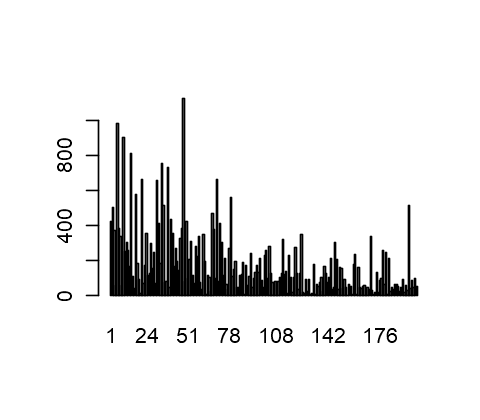

In [16]:
options(repr.plot.width=4, repr.plot.height=3.5)

## Visualize the cluster size distribution
barplot(kmode_model[[20]]$size)

In [17]:
## combine cluster solutions into the data
LT.clust <- cbind(factor(kmode_model[[20]]$cluster), LT_d2)
colnames(LT.clust)[1] <- "km_cluster"

In [18]:
## summary statistics on numeric features
kable(summary(LT_d2[, sapply(LT_d2, is.numeric)]))



|   |Unit.Price.per.K |Scheduled.Qty  |  Actual.LT    |  Quoted.LT    |Dev.Quote.Confirm |  PlannedLT    |
|:--|:----------------|:--------------|:--------------|:--------------|:-----------------|:--------------|
|   |Min.   :    1.29 |Min.   :    10 |Min.   :  1.00 |Min.   : -7.00 |Min.   :-421.00   |Min.   : 32.00 |
|   |1st Qu.: 1882.49 |1st Qu.:   600 |1st Qu.: 38.00 |1st Qu.: 59.00 |1st Qu.: -19.00   |1st Qu.: 53.00 |
|   |Median : 3545.41 |Median :  1200 |Median : 59.00 |Median : 81.00 |Median : -16.00   |Median : 57.00 |
|   |Mean   : 5009.71 |Mean   :  2650 |Mean   : 65.24 |Mean   : 85.23 |Mean   : -15.58   |Mean   : 63.01 |
|   |3rd Qu.: 6099.42 |3rd Qu.:  2600 |3rd Qu.: 84.00 |3rd Qu.:103.00 |3rd Qu.: -12.00   |3rd Qu.: 70.00 |
|   |Max.   :66721.15 |Max.   :226224 |Max.   :273.00 |Max.   :449.00 |Max.   : 403.00   |Max.   :184.00 |

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


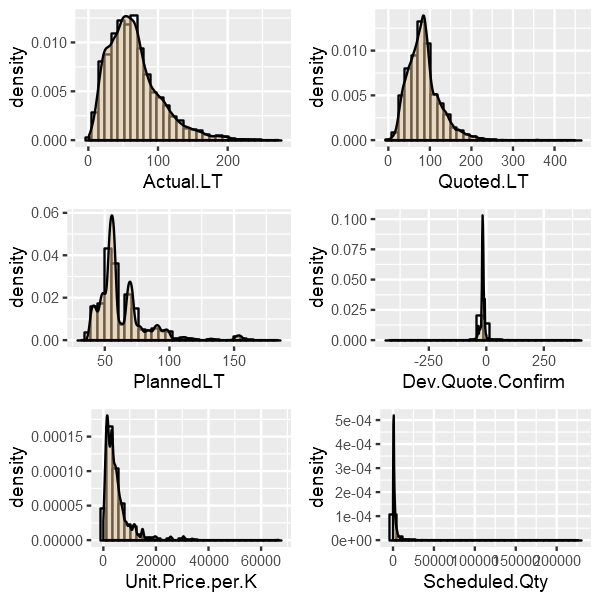

In [19]:
options(repr.plot.width=5, repr.plot.height=5)

## create density plots
p1 <- ggplot(LT_d2, aes(x=Actual.LT))+
  geom_histogram(aes(y=..density..), colour="black", fill="aliceblue")+
  geom_density(alpha=0.5, fill="burlywood")
p2 <- ggplot(LT_d2, aes(x=Quoted.LT))+
  geom_histogram(aes(y=..density..), colour="black", fill="aliceblue")+
  geom_density(alpha=0.5, fill="burlywood")
p3 <- ggplot(LT_d2, aes(x=PlannedLT))+
  geom_histogram(aes(y=..density..), colour="black", fill="aliceblue")+
  geom_density(alpha=0.5, fill="burlywood")
p4 <- ggplot(LT_d2, aes(x=Dev.Quote.Confirm))+
  geom_histogram(aes(y=..density..), colour="black", fill="aliceblue")+
  geom_density(alpha=0.5, fill="burlywood")
p5 <- ggplot(LT_d2, aes(x=Unit.Price.per.K))+
  geom_histogram(aes(y=..density..), colour="black", fill="aliceblue")+
  geom_density(alpha=0.5, fill="burlywood")
p6 <- ggplot(LT_d2, aes(x=Scheduled.Qty))+
  geom_histogram(aes(y=..density..), colour="black", fill="aliceblue")+
  geom_density(alpha=0.5, fill="burlywood")

## combining plots
library(gridExtra)
grid.arrange(p1, p2, p3, p4, p5, p6, nrow=3)

The density-based approach DBSCAN could be an option to give a more concise view. This method investigates the distance between a data point and its k-nearest neighbours and forms groups if it is within a pre-set parameter of epsilon (i.e. defining the distance that the minimum number of neighbouring data points could be reached directly from a specified core point). This parameter can be selected with the k-NN distance plot, corresponding to the turning point where k-NN distance increase drastically. Noises and outliers that are deviated in a great extent from the main groups would be isolated and classified as cluster 0 in the clustering output.

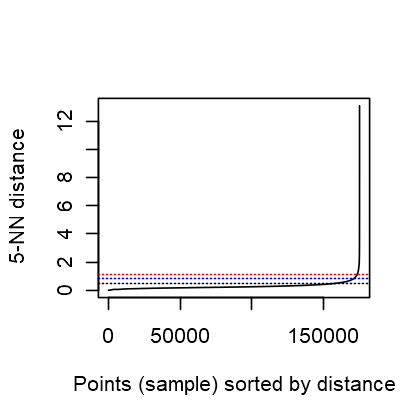

In [22]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

## perform density based clustering
library(dbscan)
library(factoextra)

## plot the k-nearest neighbor distance for determining the parameter of eps
## all numerical inputs are used
kNNdistplot(scale(LT.clust[, c(9:11, 14:16)]), k=5)
abline(h=0.5, lty=3)
abline(h=0.8, lty=3, col='blue')
abline(h=1.1, lty=3, col='red')

In [21]:
## standardized inputs to make comparable distances between data points
db <- dbscan(scale(LT_d2[, c(8:10, 13:15)]), eps=0.8, minPts=5)

In [23]:
## cluster 0 regarded as outliers: around 700 data classified as outliers
kable(t(summary(factor(db$cluster))))



|   0|     1|  2|  3|   4|   5|  6|  7|  8|  9| 10| 11| 12| 13| 14| 15| 16| 17| 18| 19| 20| 21| 22| 23| 24| 25| 26| 27| 28| 29| 30| 31|
|---:|-----:|--:|--:|---:|---:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| 703| 33233| 10| 29| 388| 437| 19| 12|  7| 23|  5|  9|  5|  9|  7|  8| 10| 40| 10|  5|  7|  9|  5|  6|  6|  5|  5|  5| 15|  5|  6|  5|

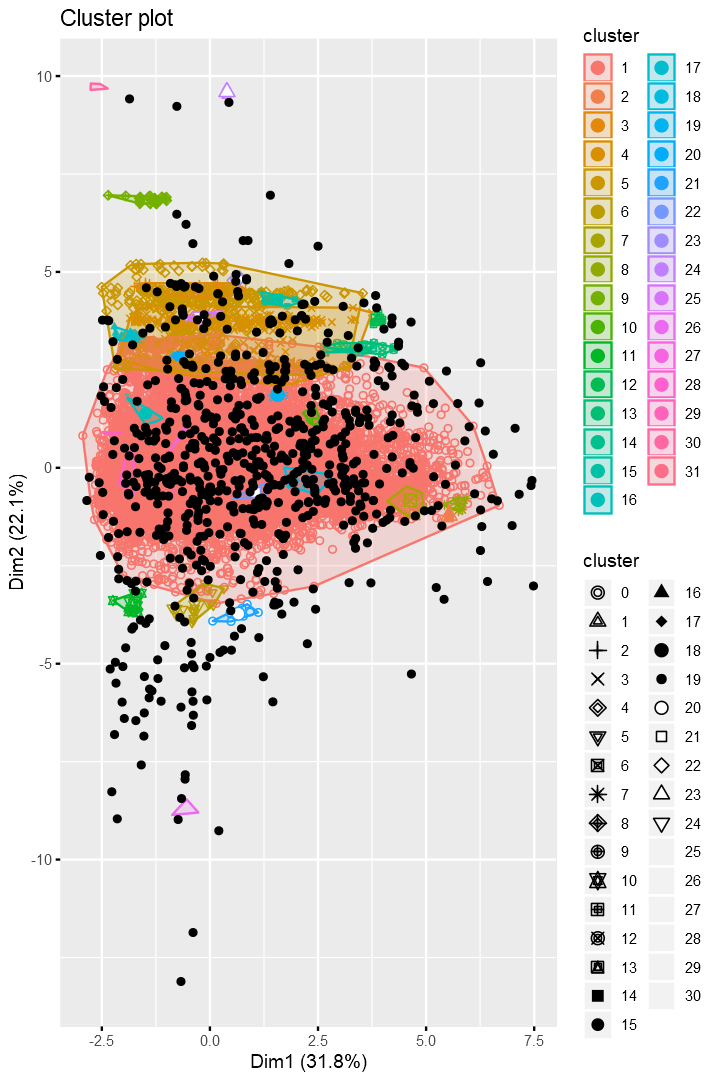

In [26]:
options(repr.plot.width=6, repr.plot.height=9)

## visualize the results in 2 dimensional space
fviz_cluster(db, LT_d2[, c(8:10, 13:15)], geom = "point")

The solution plotted on the first two dimensions includes around 54% of the total variations.

Local outlier factor score (LOF) is another measure for outlier detection, which relies on the same concepts of k-nearest-neighbours distance to define the reachability distance. The slight difference is that DBSCAN forms clusters with all density reachable points, while LOF computes a numerical score from the reachability distances with respect to each single point. A cut-off threshold is set at LOF > 1.7 as a reference, and eventually 705 outliers were identified, comparable to the results of DBSCAN (yielding 703 outliers). It would be up to the analysts to choose the cut-off score, depending on the domain contexts they were working on.

Other algorithms may include one-class SVM, isolation forest, etc.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_anomaly_comparison_001.png" width="450" height="450"/>

In [73]:
## compute the local outlier factor score
lof_score <- lof(scale(LT_d2[, c(8:10, 13:15)]), k=5)

In [75]:
## results
summary(lof_score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8336  1.0057  1.0481  1.1167  1.1414 31.9338 

In [81]:
## extract only observations with score > 2 as a threshold
out_lof <- lof_score[lof_score > 1.7]
length(out_lof)

[1] 705

#### Predicting actual LT for order processing:

Assuming a hypothetical target on optimizing the estimated lead time for processing steps like procurement and manufacture, regression models could be trained to predict the actual lead time it would likely to spend on processing one order. Three sets of methodologies and models would be constructed:

1)	Elastic-Net / L1-penalized (Lasso) / L2-penalized (Ridge) linear model:

* The categorical variables could be one-hot encoded as dummies, and be fed as features to the model. However, to deal with the sparsity and potentially overfitting and multicollinearity problems due to increase in dimensionality, regularization would be introducing penalty terms to the regression coefficients, β’s. 

* Dependng on the scaling parameter of regularization weights assigned to the L1 norm and L2 norm, Ridge regression would be more robust against overfitting, while Lasso region could eliminate some of the features when their weightings converged to zero during the training process. Elastic-net regression takes account of both L1 and L2 penalties and adjusts the tendency to one side or takes the balance of it.

<img src="https://hackernoon.com/hn-images/1*gAmw-_z6v4bG9HcnPSAK3Q.png" width="400"/>

2)	Multi-level (mixed-effect) model:

*	The categorical features manifested a nested or hierarchical structure, such that certain brands are pertaining to a particular category, certain customers operating in a particular region, and certain vendors belonging in a particular class. Meanwhile, more than one order could be created for individual product item in case of re-ordering. Under this kind of data structure, the regression coefficients may vary across the categorical levels. It can be interpreted as that the normal regression coefficients, β’s, can be expressed as another liner combinations from random-effect attributes.

Fixed Effects for explanatory numeric variables X's:

\begin{align}
Y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + \epsilon_{ij}
\end{align}

Random Effects for group variables Z:

\begin{align}
\beta_{0j} = \gamma_{00} + \gamma_{01}Z_{j} + \upsilon_{0j} \\\
\beta_{1j} = \gamma_{10} + \gamma_{11}Z_{j} + \upsilon_{1j}
\end{align}

Overall Equation:

\begin{align}
Y_{ij} = \gamma_{00} + \gamma_{01}Z_{j} + (\gamma_{10} + \upsilon_{1j})X_{ij} + \gamma_{11}Z_{j}X_{ij} + (\upsilon_{0j} + \epsilon_{ij})
\end{align}

3) Generalized additive model (GAM):

* Compared with linear regression models making a number of assumptions, e.g. independently and identically normal-distributed residuals, linearity relationships, etc. GAM model allows addition of smoothing terms of different functions, instead of fixing the predictors to be presented by their pure forms. The contributions from the smoothed features are outputted via a function, allowing non-linearity to improved the fitting performance.

\begin{align}
Y_{ij} = \beta_{0j} + f_{1}(X_{ij}) + \epsilon_{ij}
\end{align}

Before training a regressor, it is a nice idea to plot the pair-wise relationships between explanatory variables and the target variable: *Acutal.LT*. In ggplot package, we could adopt a technique called spline for fitting a smoothing curve to the scatter plots by non-parametric methods like robust regression, LOESS / LOWESS (locally (weighted) estimated scatterplot smoothing). In the training part, the observations are split into a training set (80%) and a testing set (20%). Within the training set, it is further sub-divided into 5 folds for cross-validation. 

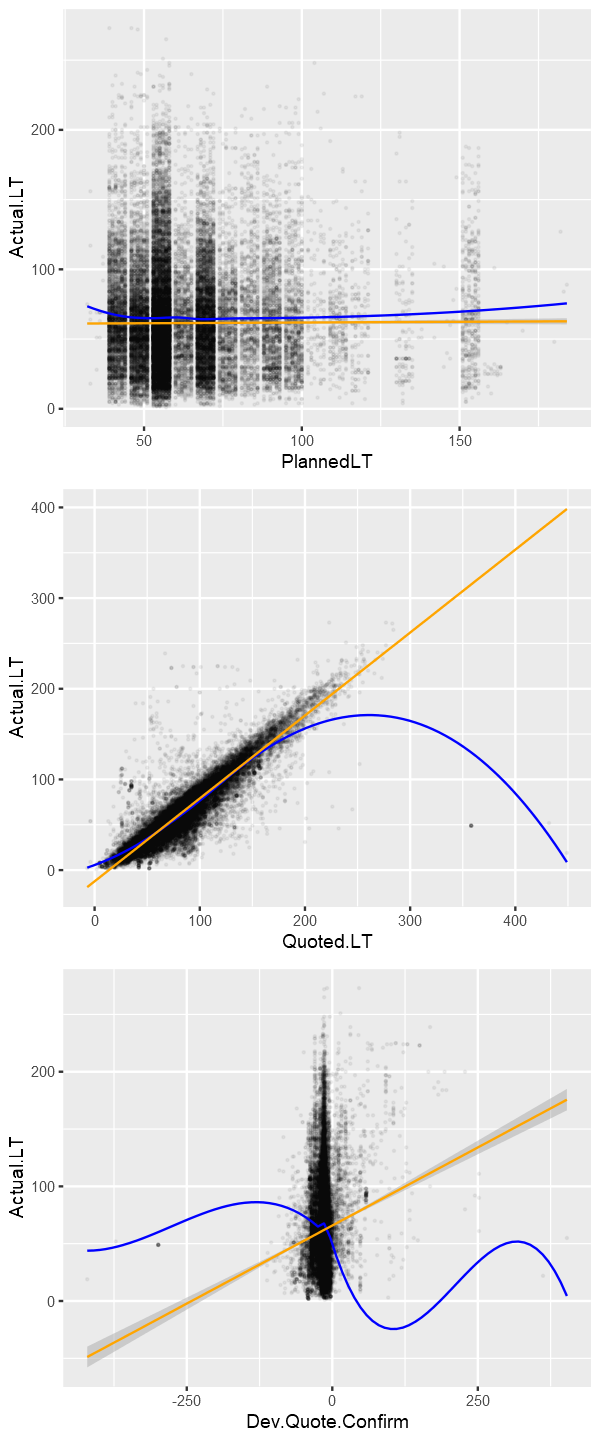

In [38]:
options(repr.plot.width=5, repr.plot.height=12)

## create spline smoothing curves: Robust regression & LOESS
LTp1 <- ggplot(LT_d2, aes(x=PlannedLT, y=Actual.LT)) +
            geom_point(size=0.2, alpha=0.05) +
            geom_smooth(method = "loess", span=0.8, size=0.5, se=FALSE, color="blue") +
            stat_smooth(method= "rlm", span=0.8, size=0.5, color="orange")
LTp2 <- ggplot(LT_d2, aes(x=Quoted.LT, y=Actual.LT)) +
            geom_point(size=0.2, alpha=0.05) +
            geom_smooth(method = "loess", span=0.8, size=0.5, se=FALSE, color="blue") +
            stat_smooth(method= "rlm", span=0.8, size=0.5, color="orange")
LTp3 <- ggplot(LT_d2, aes(x=Dev.Quote.Confirm, y=Actual.LT)) +
            geom_point(size=0.2, alpha=0.05) +
            geom_smooth(method = "loess", span=0.8, size=0.5, se=FALSE, color="blue") +
            stat_smooth(method= "rlm", span=0.8, size=0.5, color="orange")

## combining plots
grid.arrange(LTp1, LTp2, LTp3, nrow=3)

In [27]:
## Model Training
# Randomly shuffle the data
LT_random <- LT.clust[sample(nrow(LT.clust)), ]

# Hold out 20% for test data
Train_size = sample(seq_len(nrow(LT_random)), size=0.8*nrow(LT_random))
LT_Train = LT_random[Train_size, ]
LT_Test = LT_random[-Train_size, ]

# Create 5 equally size folds for cross-validation on training data
folds <- cut(seq(1, nrow(LT_Train)), breaks=5, labels=FALSE)

1) Elastic-Net / Lasso / Ridge regression linear model:

For the elastic-net regularization, the popular “glmnet” package had been used to conduct a cross validation to select the alpha (i.e. the weighting parameter of L1-norm and L2-norm for regression coefficient penalties). The *model.matrix()* function created a matrix of binary attributes from the categorical features. One set used all raw column inputs, while one set used the cluster membership column as the only input.

In [28]:
## Create dummy variables for categorical columns as inputs
LT_dummy_all <- model.matrix(~ Item + Vendor.Class + Vendor + Category + 
                               Brand + Region + Customer + FactorySize + 
                               MinOrderQty, data=LT_Train)[, -1]
LT_dummy_all <- cbind(LT_Train[, c(9:11, 14:16)], LT_dummy_all)

LT_dummy_cluster <- model.matrix(~ km_cluster, data=LT_Train)[, -1]
LT_dummy_cluster <- cbind(LT_Train[, c(9:11, 14:16)], LT_dummy_cluster)

In [29]:
### Making list of empty lists for each cv.glmnet()
library(glmnet)
### fit regularized elastic-net models with different alphas
cv_elastNet = rep(list(list()), 11)
for (i in 1:11) {
  cv_elastNet[[i]] <- cv.glmnet(as.matrix(LT_dummy_all[, c(1:2, 4:ncol(LT_dummy_all))]), 
                                as.matrix(LT_dummy_all[, 3]), alpha=(i-1)/10, 
                                type.measure="mse", nfolds=5, 
                                family="gaussian", foldid=folds)
}
cv_elastNet_clust = rep(list(list()), 11)
for (i in 1:11) {
  cv_elastNet_clust[[i]] <- cv.glmnet(as.matrix(LT_dummy_cluster[, c(1:2, 4:ncol(LT_dummy_cluster))]), 
                                      as.matrix(LT_dummy_cluster[, 3]), alpha=(i-1)/10, 
                                      type.measure="mse", nfolds=5, 
                                      family="gaussian", foldid=folds)
}

Loading required package: Matrix
Loaded glmnet 2.0-16



The mean squared error against different log-lambda values had been plotted with the following codes and outputs (lambda in this package is a scaling parameter for determining the degree of penalties).

The minimum mean squared errors (measure of cross validation errors applied in this context) across models fitted with alpha values from 0 to 1 incremented by 0.1 were extracted, except for a slightly higher error for alpha = 0 (a Ridge regression), other models achieved comparable minimum MSE with small lambda values. One way would be choosing to determine the desired range of magnitudes of lambda before selecting the alpha, depending on whether the objective was to have smaller errors, or to have greater penalties. For the all-inputs model, alpha = 0.3 would be the selected for this exercise; while for the cluster-input model, alpha = 0.4 or 0.5 would be reasonable range.

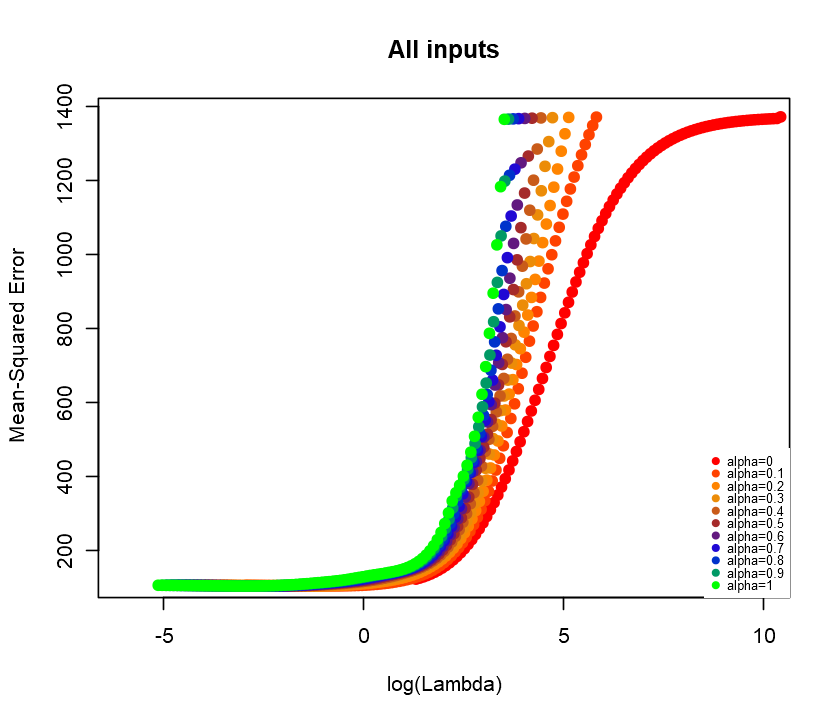

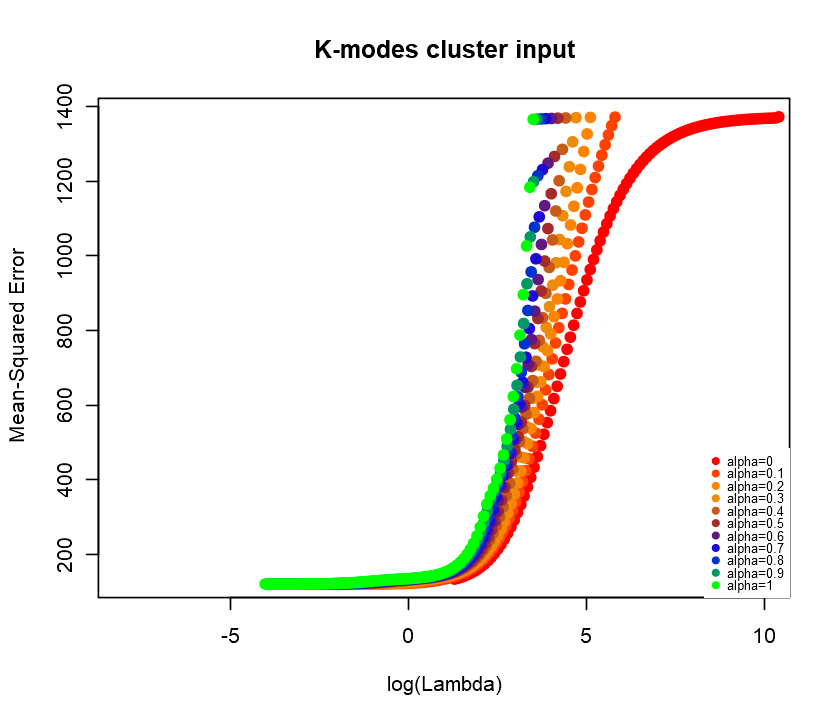

In [30]:
options(repr.plot.width=7, repr.plot.height=6)

rbPal <- colorRampPalette(c('red','orange','brown','blue','green'))
### MSE vs log-lambda
plot(log(cv_elastNet[[1]]$lambda), cv_elastNet[[1]]$cvm, pch=19, col=rbPal(11)[1], 
     xlab="log(Lambda)", ylab=cv_elastNet[[1]]$name, 
     main="All inputs", xlim=c(-6, 10))
for (j in 2:11){
  points(log(cv_elastNet[[j]]$lambda), cv_elastNet[[j]]$cvm, pch=19, col=rbPal(11)[j])
}
legend("bottomright", legend=c("alpha=0","alpha=0.1","alpha=0.2","alpha=0.3", "alpha=0.4","alpha=0.5",
                               "alpha=0.6","alpha=0.7","alpha=0.8","alpha=0.9", "alpha=1"), 
                      col=rbPal(11), pch=19, cex=0.6, box.lty=0)

plot(log(cv_elastNet_clust[[1]]$lambda), cv_elastNet_clust[[1]]$cvm, pch=19, col=rbPal(11)[1], 
     xlab="log(Lambda)", ylab=cv_elastNet_clust[[1]]$name,       
     main="K-modes cluster input", xlim=c(-8, 10))
for (j in 2:11){
  points(log(cv_elastNet_clust[[j]]$lambda), cv_elastNet_clust[[j]]$cvm, pch=19, col=rbPal(11)[j])
}
legend("bottomright", legend=c("alpha=0","alpha=0.1","alpha=0.2","alpha=0.3","alpha=0.4","alpha=0.5",
                               "alpha=0.6","alpha=0.7","alpha=0.8","alpha=0.9", "alpha=1"), 
                      col=rbPal(11), pch=19, cex=0.6, box.lty=0)

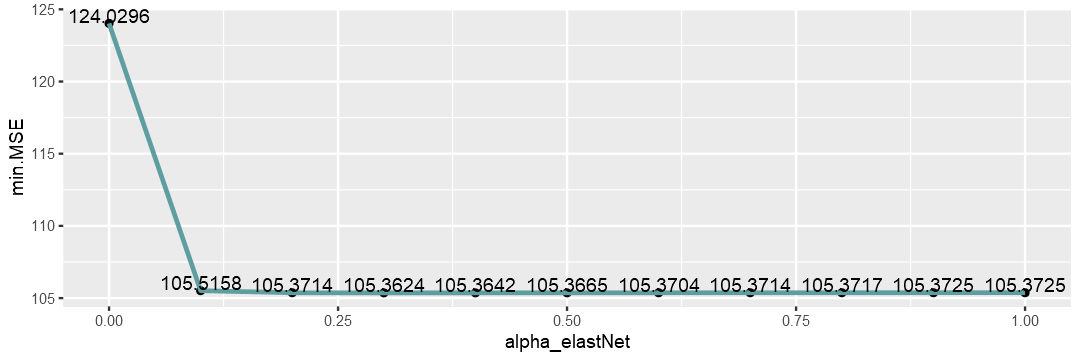

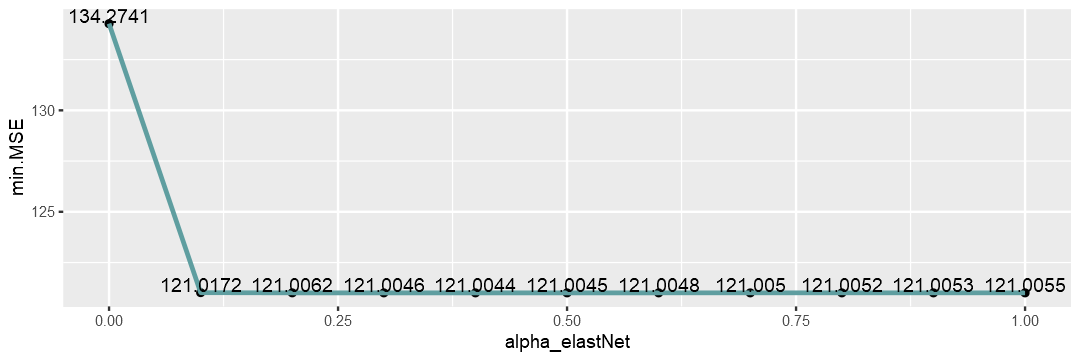

In [31]:
options(repr.plot.width=9, repr.plot.height=3)

### minimum MSE achieved for different alphas
alpha_elastNet <- rep(seq(0, 1, 0.1), each=2)
cv.min.mse <- list()
for (i in 1:11) {
  cv.min.mse[[i]] <- list(round(min(cv_elastNet[[i]]$cvm), 4), 
                          round(min(cv_elastNet_clust[[i]]$cvm), 4))
}
grp <- rep(c(1,2), 11)

cv.df <- data.frame(alpha_elastNet, unlist(cv.min.mse), grp)
colnames(cv.df)[2] <- "min.MSE"

ggplot(cv.df[cv.df$grp==1, ], aes(alpha_elastNet, min.MSE, label=min.MSE)) + 
  geom_point() + 
  geom_line(color="cadetblue", size=1.0) + 
  geom_text(vjust=0, nudge_y=0.05)

ggplot(cv.df[cv.df$grp==2, ], aes(alpha_elastNet, min.MSE, label=min.MSE)) + 
  geom_point() + 
  geom_line(color="cadetblue", size=1.0) + 
  geom_text(vjust=0, nudge_y=0.05)

2) Multi-level (mixed effects) model:

To fit a mixed model, in this example, for the random effects, a random intercept had been fitted for each of the hierarchical groups (e.g. supplier class and supplier name; product category and product brand), and it was expressed as (1 | group A / group B / group C...) in the formula. If the random effect was specified in forms of (feature A | group A / group B / group C...), then a random slope would be fitted for the fixed effects of “feature A” for each group variable.

The random effects in the output would show the variance of each hierarchical group(s) contributed to the target variable, while the fixed effects of main features would give respective p-values on the significance of the estimates. To ensure normality, I applied scaling method to normalize the numerical features.

In [32]:
library(lme4)
library(lmerTest)
library(jmvcore)

mixed.model <- lmer(Actual.LT ~ (1|Category/Brand/Item) + 
                    (1|Vendor.Class/Vendor) + (1|Region/Customer) + 
                    scale(Unit.Price.per.K) + scale(Scheduled.Qty) + 
                    scale(PlannedLT) + scale(Quoted.LT) + 
                    scale(Dev.Quote.Confirm), data = LT_Train)
summary(mixed.model)


Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step


Attaching package: 'jmvcore'

The following object is masked from 'package:Matrix':

    format

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:base':

    endsWith, format, startsWith



Linear mixed model fit by REML. t-tests use Satterthwaite's method ['lmerModLmerTest']
Formula: Actual.LT ~ (1 | Category/Brand/Item) + (1 | Vendor.Class/Vendor) +      (1 | Region/Customer) + scale(Unit.Price.per.K) + scale(Scheduled.Qty) +      scale(PlannedLT) + scale(Quoted.LT) + scale(Dev.Quote.Confirm)
   Data: LT_Train

REML criterion at convergence: 210062.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-21.5091  -0.3836   0.0543   0.4768  17.6697 

Random effects:
 Groups                Name        Variance Std.Dev.
 Item:(Brand:Category) (Intercept) 23.3516  4.832   
 Customer:Region       (Intercept) 51.1118  7.149   
 Brand:Category        (Intercept)  2.5901  1.609   
 Vendor:Vendor.Class   (Intercept) 18.2823  4.276   
 Category              (Intercept)  0.2171  0.466   
 Region                (Intercept) 18.9768  4.356   
 Vendor.Class          (Intercept) 10.0398  3.169   
 Residual                          95.4074  9.768   
Number of obs: 28038, gro

It is better to evaluate the generalized linear mixed model (GLMM) assumptions by conducting diagnostics on linearity, constant variance, and normality supposed to be guaranteed for residuals. The residuals did not change with the response variable data in the training set, nor across the range of fitted values. The QQ-plot had shown deviations on the high and low quantiles, and the density plot seemed to be have a broader and flat-top peak than a normal curve. The residuals might not strictly follow normality, which might be caused by some extremes in the response varaible. There might be improvements through re-fitting the model excluding outliers identified in the previous analysis, or trying to do transformations on the features.

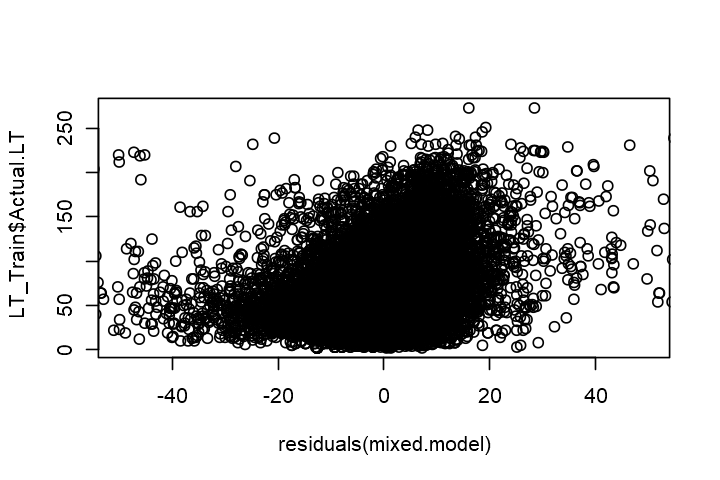

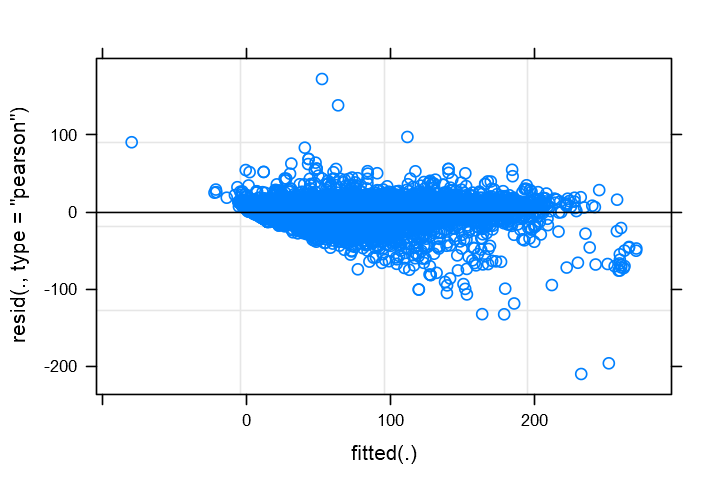

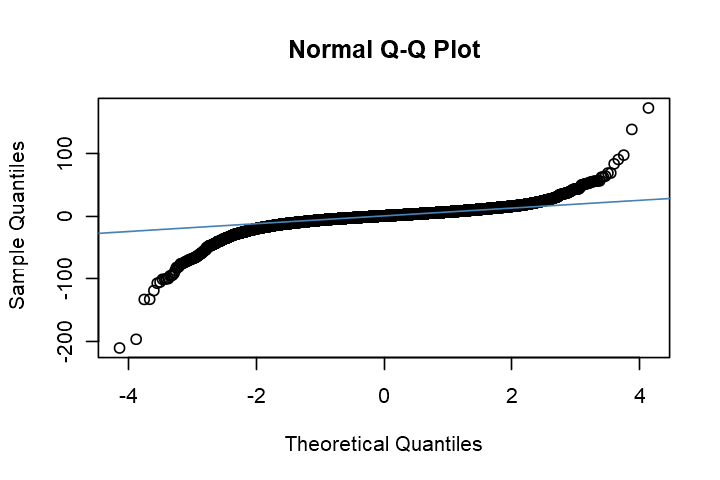

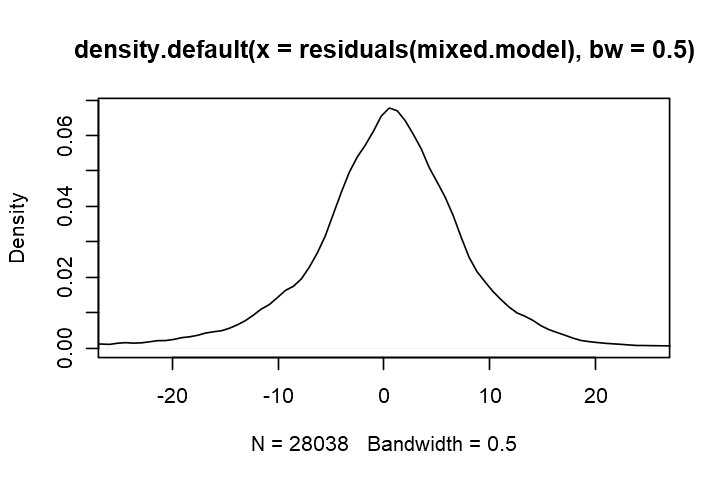

In [50]:
options(repr.plot.width=6, repr.plot.height=4)

## linearity of residuals
plot(residuals(mixed.model), LT_Train$Actual.LT, xlim=c(-50,50))

## plotting residuals against fitted values on the outcome (variance)
plot(mixed.model)

## normality of residuals
qqnorm(residuals(mixed.model))
qqline(residuals(mixed.model), col="steelblue")
plot(density(residuals(mixed.model), bw=0.5), xlim=c(-25,25))

3) Generalized Additive Model:

Implementations of GAM would require a smoothing term requires s() function in the formula, corresponding to the smoothing function for the predictors. It was critical for the manipulation on the degree of freedom (df) for each of the concerned predictors in the model. In mgcv package, gam() function would default the degree of freedom to 10 as maximum. The p-values given for the estimated df for each predictor would indicate whether higher degree of freedom is required. If estimated df (edf) was close to specified value of k, it needed to be re-tried with increasing df. We could preliminarily fit a model with df = 30 to search for the estimated df for all predictors. After searching for the probable values for estimated df, we could use fx = True to fix the degree of freedom as our model. The parameter obtained would be optimized by the method of restricted maximum likelihood (REML).

library(mgcv)

gam.model <- mgcv::gam(Actual.LT ~ s(Unit.Price.per.K, k=30) + s(Scheduled.Qty, k=30) + s(PlannedLT, k=30) + s(Quoted.LT, k=30) + 
                       s(Dev.Quote.Confirm, k=30), data=LT_Train, method = "REML")


Method: REML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-2.49698e-05,9.21313e-07]
(score 106451.5 & scale 114.5937).
Hessian positive definite, eigenvalue range [0.7676691,14016.03].
Model rank =  146 / 146 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                        k'   edf k-index p-value    
s(Unit.Price.per.K)  29.00 22.95    0.87  <2e-16 ***
s(Scheduled.Qty)     29.00  3.55    0.98    0.12    
s(PlannedLT)         29.00 14.92    1.01    0.83    
s(Quoted.LT)         29.00 14.49    1.03    1.00    
s(Dev.Quote.Confirm) 29.00 28.48    0.99    0.14    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


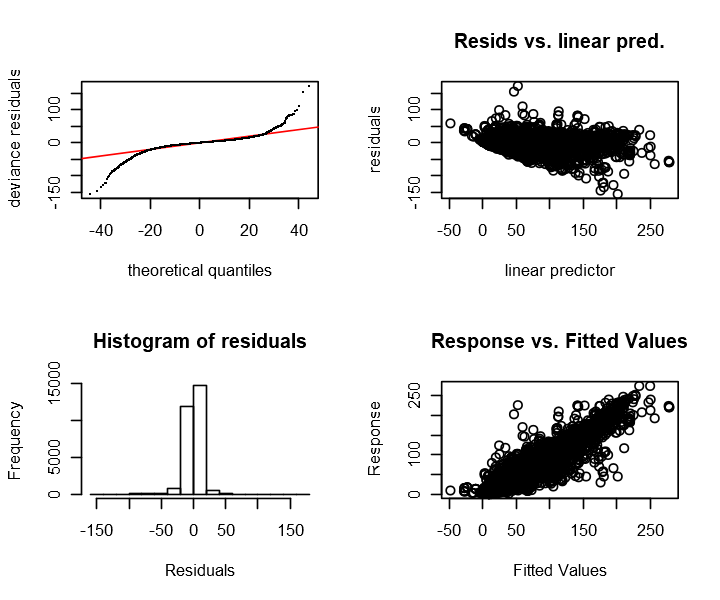

In [45]:
options(repr.plot.width=6, repr.plot.height=5)
gam.check(gam.model)

In [47]:
summary(gam.model)


Family: gaussian 
Link function: identity 

Formula:
Actual.LT ~ s(Unit.Price.per.K, k = 30) + s(Scheduled.Qty, k = 30) + 
    s(PlannedLT, k = 30) + s(Quoted.LT, k = 30) + s(Dev.Quote.Confirm, 
    k = 30)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 65.23943    0.06393    1020   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                        edf Ref.df         F  p-value    
s(Unit.Price.per.K)  22.948 26.190     8.489  < 2e-16 ***
s(Scheduled.Qty)      3.551  4.462    11.804 3.52e-10 ***
s(PlannedLT)         14.917 17.735    15.837  < 2e-16 ***
s(Quoted.LT)         14.494 17.330 16638.285  < 2e-16 ***
s(Dev.Quote.Confirm) 28.476 28.953   878.056  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.916   Deviance explained = 91.7%
-REML = 1.0645e+05  Scale est. = 114.59    n = 28038

Then, it came to the core part of model selection through cross validation, that fitted respectively 3 sets of models attempted above, with all features in the original data, and with the cluster memberships. As set up before, it would undergo a 5-fold cross validation. For the regularized elastic-net models, the lambda parameter was set to be optimized at which the simplest model within one standard error from the lambda corresponding to minimum MSE would be returned. To evaluate the cross-validation results, root mean squared errors, mean absolute deviations and R-square values for each fold were recorded to a data frame for revision.

In [55]:
Valid_LT = list()
for(i in 1:5){
  # Segement your data by fold using the which() function 
  Val_Ind <- which(folds==i, arr.ind=TRUE)
  ValidData <- LT_Train[Val_Ind, ]
  trainData <- LT_Train[-Val_Ind, ]
  
  # Dummy-encoded data structure for glmnet
  va_dummy_all <- LT_dummy_all[Val_Ind, ]
  tr_dummy_all <- LT_dummy_all[-Val_Ind, ]
  va_dummy_cluster <- LT_dummy_cluster[Val_Ind, ]
  tr_dummy_cluster <- LT_dummy_cluster[-Val_Ind, ]
  
  # Retrieve actual value data for estimation of prediction errors
  Actual <- ValidData[, 11]
  Actual_dummy_all <- va_dummy_all[, 3]
  Actual_dummy_cluster <- va_dummy_cluster[, 3]
  
  # Error Handling:
  # Reallocation if there are levels in validation set not existing in training set
  for (c in 1:8){
    if (length(setdiff(ValidData[, c], trainData[, c])) > 0){
        newlevels <- setdiff(ValidData[, c], trainData[, c])
        trainData <- rbind(trainData, ValidData[ValidData[, c] %in% newlevels, ])
        ValidData <- ValidData[!(ValidData[, c] %in% newlevels), ]
        Actual <- ValidData[, 11]
    }
  }

  # Elastic-Net regularized model
  fit1 <- glmnet(as.matrix(tr_dummy_all[, c(1:2, 4:ncol(tr_dummy_all))]), 
                 as.matrix(tr_dummy_all[, 3]), 
                 alpha = 0.3, family = "gaussian", maxit = 1000)
  fit2 <- glmnet(as.matrix(tr_dummy_cluster[, c(1:2, 4:ncol(tr_dummy_cluster))]), 
                 as.matrix(tr_dummy_cluster[, 3]), 
                 alpha = 0.4, family = "gaussian", maxit = 1000)
    
  # Mixed-effect (multi-level) model
  # for observations in nested / hierarchical structure by specifying random effects
  fit3 <- lmer(Actual.LT ~ (1|Category/Brand/Item) + (1|Vendor.Class/Vendor) + (1|Region/Customer) + 
                            scale(Unit.Price.per.K) + scale(Scheduled.Qty) + 
                            scale(PlannedLT) + scale(Quoted.LT) + scale(Dev.Quote.Confirm), 
                            data = trainData)
  fit4 <- lmer(Actual.LT ~ (1|km_cluster) + scale(Unit.Price.per.K) + scale(Scheduled.Qty) + 
                            scale(PlannedLT) + scale(Quoted.LT) + scale(Dev.Quote.Confirm), 
                            data = trainData)

  # Generalized additive model (GAM)
  fit5 <- mgcv::gam(Actual.LT ~ s(Unit.Price.per.K, k=23) + s(Scheduled.Qty, k=4) + 
                                s(PlannedLT, k=15) + s(Quoted.LT, k=14) + 
                                s(Dev.Quote.Confirm, k=28), data=trainData, method="REML", fx=TRUE)
  
  ### Calculate prediction errors by RMSE / MAD
  Valid1 <- predict(fit1, as.matrix(va_dummy_all[, c(1:2, 4:ncol(va_dummy_all))]), 
                    type="response", s = cv_elastNet[[4]]$lambda.1se)
  Err1_rmse = sqrt(sum((Valid1 - Actual_dummy_all)^2)*(1/length(Valid1)))
  Err1_mad = sum(abs(Valid1 - Actual_dummy_all))*(1/length(Valid1))
  Err1_Rsq = 1 - sum((Valid1 - Actual_dummy_all)^2) / sum((Actual_dummy_all - mean(Actual_dummy_all))^2)
  
  Valid2 <- predict(fit2, as.matrix(va_dummy_cluster[, c(1:2, 4:ncol(va_dummy_cluster))]), 
                    type="response", s = cv_elastNet_clust[[5]]$lambda.1se)
  Err2_rmse = sqrt(sum((Valid2 - Actual_dummy_cluster)^2)*(1/length(Valid2)))
  Err2_mad = sum(abs(Valid2 - Actual_dummy_cluster))*(1/length(Valid2))
  Err2_Rsq = 1 - sum((Valid2 - Actual_dummy_cluster)^2) / 
                 sum((Actual_dummy_cluster - mean(Actual_dummy_cluster))^2)

  Valid3 <- predict(fit3, ValidData, type="response", allow.new.levels=TRUE)
  Err3_rmse = sqrt(sum((Valid3 - Actual)^2)*(1/length(Valid3)))
  Err3_mad = sum(abs(Valid3 - Actual))*(1/length(Valid3))
  Err3_Rsq = 1 - sum((Valid3 - Actual)^2) / sum((Actual - mean(Actual))^2)

  Valid4 <- predict(fit4, ValidData, type="response", allow.new.levels=TRUE)
  Err4_rmse = sqrt(sum((Valid4 - Actual)^2)*(1/length(Valid4)))
  Err4_mad = sum(abs(Valid4 - Actual))*(1/length(Valid4))
  Err4_Rsq = 1 - sum((Valid4 - Actual)^2) / sum((Actual - mean(Actual))^2)
    
  Valid5 <- predict(fit5, ValidData, type="response", allow.new.levels=TRUE)
  Err5_rmse = sqrt(sum((Valid5 - Actual)^2)*(1/length(Valid5)))
  Err5_mad = sum(abs(Valid5 - Actual))*(1/length(Valid5))
  Err5_Rsq = 1 - sum((Valid5 - Actual)^2) / sum((Actual - mean(Actual))^2)
  
  Valid_LT[i] = list(c(Err1_rmse, Err2_rmse, Err3_rmse, Err4_rmse, Err5_rmse,
                       Err1_mad, Err2_mad, Err3_mad, Err4_mad, Err5_mad,
                       Err1_Rsq, Err2_Rsq, Err3_Rsq, Err4_Rsq, Err5_Rsq))
  ## print the progress upon completing a run
  cat(i*20, '%')
}

20 %40 %60 %80 %100 %

In [59]:
## gather the validation measures into dataframe
options(scipen = 999) ## disable scientific notation
measure <- c(rep("Error_RMSE", 5), rep("Error_MAD", 5), rep("R-square", 5))
model <- rep(1:5, 3)
err <- as.data.frame(Valid_LT)
colnames(err) <- c("fold 1", "fold 2", "fold 3", "fold 4", "fold5")
select_LT <- cbind(measure, model, err)
select_LT

measure,model,fold 1,fold 2,fold 3,fold 4,fold5
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Error_RMSE,1,10.4057520,10.0695533,10.2922213,10.3962367,10.5499843
Error_RMSE,2,10.9943293,10.8925185,11.0299945,11.1380693,11.6563760
Error_RMSE,3,10.2370050,9.8297703,10.1215127,10.2195011,10.4411477
Error_RMSE,4,10.8481756,10.6804772,10.8709015,10.9746590,11.5746348
Error_RMSE,5,10.9914307,10.1607921,11.4053967,11.1329972,10.7363489
Error_MAD,1,6.6635428,6.4121775,6.5473487,6.6546738,6.5810627
Error_MAD,2,7.1263353,6.9310910,7.0148945,7.1173288,7.1650891
Error_MAD,3,6.4989526,6.2105467,6.4002633,6.5361792,6.4236812
Error_MAD,4,6.9342744,6.7214142,6.7976717,6.8846417,6.9618534


From the above summary table, all models showed comparable results and achieved an average performance within 6 to 7 days deviated from the actual lead time it had taken to finish processing an order in the supply chain. In comparison, models using the grouped cluster memberships have slightly larger biases, which might be explained from the reduced purity or the within-group variations introduced during clustering. The mixed-effect model using non-cluster categorical inputs yielded the highest scores in the 3 metrics, and hence the smallest training errors.

In [ ]:
### investigate prediction errors on the testing set
### re-train with unseen levels in the categories in case
for (c in 1:8){
  if (length(setdiff(LT_Test[, c], LT_Train[, c])) > 0){
    newlevel <- setdiff(LT_Test[, c], LT_Train[, c])
    LT_Train.new <- rbind(LT_Train, LT_Test[LT_Test[, c] %in% newlevel, ])
    LT_Test.new <- LT_Test[!(LT_Test[, c] %in% newlevel), ]
  }
}
LT_dummy_all.new <- model.matrix(~ Item + Vendor.Class + Vendor + Category + 
                               Brand + Region + Customer + FactorySize + 
                               MinOrderQty, data=LT_Train.new)[, -1]
LT_dummy_all.new <- cbind(LT_Train.new[, c(9:11, 14:16)], LT_dummy_all.new)
LT_dummy_all.new_val <- model.matrix(~ Item + Vendor.Class + Vendor + Category + 
                               Brand + Region + Customer + FactorySize + 
                               MinOrderQty, data=LT_Test.new)[, -1]
LT_dummy_all.new_val <- cbind(LT_Test.new[, c(9:11, 14:16)], LT_dummy_all.new_val)

## find the testing error for the sets of models to predict on testing set
model_for_test.fit1 <- glmnet(as.matrix(LT_dummy_all.new[, c(1:2, 4:ncol(LT_dummy_all.new))]), 
                              as.matrix(LT_dummy_all.new[, 3]), alpha = 0.3, 
                              family = "gaussian", maxit = 1000)
model_for_test.fit2 <- lmer(Actual.LT ~ (1|Category/Brand/Item) + 
                                        (1|Vendor.Class/Vendor) + (1|Region/Customer) + 
                                        scale(Unit.Price.per.K) + scale(Scheduled.Qty) + 
                                        scale(PlannedLT) + scale(Quoted.LT) + 
                                        scale(Dev.Quote.Confirm), data = LT_Train.new)

pred1 <- predict(model_for_test.fit1, 
                 as.matrix(LT_dummy_all.new_val[, c(1:2, 4:ncol(LT_dummy_all.new_val))]), 
                 type="response", s = cv_elastNet[[4]]$lambda.1se)
Test_err1_rmse = sqrt(sum((pred1 - LT_dummy_all.new_val[, 3])^2)*(1/length(pred1)))
Test_err1_mad = sum(abs(pred1 - LT_dummy_all.new_val[, 3]))*(1/length(pred1))
Test_err1_Rsq = 1 - sum((pred1 - LT_dummy_all.new_val[, 3])^2) / 
                    sum((LT_dummy_all.new_val[, 3] - mean(LT_dummy_all.new_val[, 3]))^2)

pred2 <- predict(model_for_test.fit2, LT_Test.new, type="response", allow.new.levels = TRUE)
Test_err2_rmse <- sqrt(sum((pred2 - LT_Test.new[, 11])^2)*(1/length(pred2)))
Test_err2_mad <- sum(abs(pred2 - LT_Test.new[, 11]))*(1/length(pred2))
Test_err2_Rsq <- 1 - sum((pred2 - LT_Test.new[, 11])^2) / 
                     sum((LT_Test.new[, 11] - mean(LT_Test.new[, 11]))^2)

Test.err <- list(Test_err1_rmse,Test_err2_rmse,
                 Test_err1_mad,Test_err2_mad,
                 Test_err1_Rsq,Test_err2_Rsq)

In [68]:
Test.err.df <- cbind(unlist(Test.err), 
                     c(rep("Error_RMSE", 2), 
                       rep("Error_MAD", 2), 
                       rep("R-square", 2)), 
                     rep(1:2, 2))
Test.err.df <- as.data.frame(Test.err.df)
colnames(Test.err.df) <- c("Test error", "measure", "model")
Test.err.df

Test error,measure,model
<fct>,<fct>,<fct>
10.1016813961665,Error_RMSE,1
9.92745521730114,Error_RMSE,2
6.64244513334298,Error_MAD,1
6.46778929095555,Error_MAD,2
0.927107964112946,R-square,1
0.929600654776845,R-square,2


The prediction errors on the testing set appeared to be quite close to the cross-validation errors. It gave an absolute deviation averagely about 6.47 days.